# Environmental Analytics CA 

### Case Study: Can I visualize earthquake maps for a USA region using Satelite Data and evaluate their impact on local infrastructure

##### Heejin Yoon 
##### 26-04-2022

Objectives:
This is report contains a spatial database of earthquakes that occured in the United States. Using this data, we will explore it using a variety of techniques and create interactive maps based on the data.

After that, we will inspect Satellite image of areas in America (San Fernando Valley of northern Los Angeles) that have been impacted by earthquake in the past.

Finally, we will attempt to predict the earthquake based on our earthquake dataset.
  


# Retrieve and set up Data

In [1]:
pip install geopandas

In [2]:
pip install geojson

In [3]:
pip install earthpy

In [4]:
pip install rioxarray 

In [5]:
pip install pygeos

In [6]:
pip install rtree

In [7]:
# Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import folium
from folium import plugins
from folium.plugins import HeatMap
from pyproj import CRS
import shapely
import fiona
import requests
import geojson
import pygeos

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import rioxarray as rxr

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [8]:
# get the significant earthquakes, 1965-2016 dataset 
!git clone https://github.com/heejinyoon/GIS_EarthquakeUS.git

fatal: destination path 'GIS_EarthquakeUS' already exists and is not an empty directory.


In [9]:
!ls

Archive.zip	  B03-19940117.tif  B06-19940117.tif  GIS_EarthquakeUS
B01-19940117.tif  B04-19940117.tif  B07-19940117.tif  __MACOSX
B02-19940117.tif  B05-19940117.tif  B08-19940117.tif  sample_data


In [10]:
# read the 'earthquake' table in to a pandas dataframe 
df = pd.read_csv("../content/GIS_EarthquakeUS/database.csv")
# drop the columns with missing values
missing_values = [col for col in df.columns
                  if df[col].isnull().any()]

df = df.drop(missing_values, axis=1)

#Data preprocessing

Steps involved in Data preprocessing


*   Parsing Date: Parsed Date to dtype datetime64(ns)
*   Parsing Time: Parsed Time to dtype timedelta64
*   Adding Attributes:
    1. Date_Time : This column contains parsed values of datatime combined
    2. Days : This column contains parsed days of week




In [11]:
# parsing datetime
# explore the length of date and time objects 
length = df["Date"].str.len()
length.value_counts()

length_ = df["Time"].str.len()
length_.value_counts()

8     23409
24        3
Name: Time, dtype: int64

In [12]:
# having a look at the wrong datapoints
wrongdates = np.where([length == 24])[1]
print("Wrong dates:", wrongdates)
df.loc[wrongdates]

wrongtime = np.where([length_ == 24])[1]
print("Wrong time:", wrongtime)
df.loc[wrongtime]

Wrong dates: [ 3378  7512 20650]
Wrong time: [ 3378  7512 20650]


Date                      Time  Latitude  \
3378   1975-02-23T02:58:41.000Z  1975-02-23T02:58:41.000Z     8.017   
7512   1985-04-28T02:53:41.530Z  1985-04-28T02:53:41.530Z   -32.998   
20650  2011-03-13T02:23:34.520Z  2011-03-13T02:23:34.520Z    36.344   

       Longitude        Type  Depth  Magnitude          ID Source  \
3378     124.075  Earthquake  623.0        5.6  USP0000A09     US   
7512     -71.766  Earthquake   33.0        5.6  USP0002E81     US   
20650    142.344  Earthquake   10.1        5.8  USP000HWQP     US   

      Location Source Magnitude Source    Status  
3378               US               US  Reviewed  
7512               US              HRV  Reviewed  
20650              US             GCMT  Reviewed

In [13]:
# fix the wrong dates
df.loc[3378, "Date"] = "02/23/1975"
df.loc[3378, "Time"] = "02:58:41"
df.loc[7512, "Date"] = "04/28/1985"
df.loc[7512, "Time"] = "02:53:41"
df.loc[20650, "Date"] = "03/13/2011"
df.loc[20650, "Time"] = "02:23:34"

In [14]:
# Selecting only earthquakes in USA
index_USA = df[(df['Latitude'] >= 26) & (df['Latitude'] <= 47) & (df['Longitude'] <= -68) & (df['Longitude'] >= -121)].index
index_USA_ = df[(df['Latitude'] >= 54) & (df['Latitude'] <= 70) & (df['Longitude'] <= -141) & (df['Longitude'] >= -166)].index

In [15]:
index_USA.shape

(154,)

In [16]:
index_USA_.shape

(235,)

In [17]:
temp = df.loc[index_USA]
temp1 = df.loc[index_USA_]

In [18]:
df_ = pd.concat([temp, temp1], ignore_index=True)

In [19]:
# After data preprocessing, Create GeoDataFrame for Earthquake
earthquakes = gpd.GeoDataFrame(df_, geometry=gpd.points_from_xy(df_.Longitude, df_.Latitude))

In [20]:
# specify the url for the USA states
url = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_1_states_provinces_shp.geojson"

# specify parameters (read data in json format)
params = dict(service='WFS',
              version='2.0.0',
              request='GetFeature',
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
states = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

In [21]:
# Define crs to WGS84
earthquakes.crs = CRS.from_epsg(4326).to_wkt()
earthquakes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
states.crs = CRS.from_epsg(4326).to_wkt()
states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Explore data

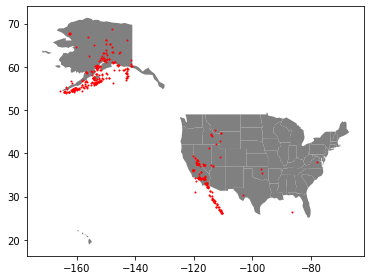

In [23]:
# Create a figure with one subplot
fig, ax = plt.subplots()
# Plot polygons
states.plot(ax=ax, facecolor='gray')
# Plot points
earthquakes.plot(ax=ax, color='red', markersize=1)
plt.tight_layout()

## Top 10 Earthquakes in USA 

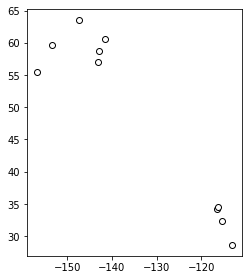

In [24]:
# Top 10 Earthquakes in USA 
ax = earthquakes.nlargest(10, 'Magnitude').plot(
    color='white', edgecolor='black')


plt.tight_layout()

In [25]:
import rtree

In [26]:
# Make a geodataframe that contains the top 10 Earthquakes in USA
# top 10 earthquakes
top10 = earthquakes.nlargest(10, 'Magnitude')

# Join Geodataframes together
top_polygon = gpd.sjoin(states, top10, op='contains')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


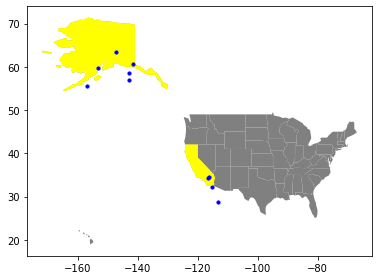

In [27]:
# Create a figure with one subplot
fig, ax = plt.subplots()
# Plot polygons
states.plot(ax=ax, facecolor='gray')
# Plot points
top_polygon.plot(ax=ax, color='yellow', markersize=2)
top10.plot(ax=ax, color='blue', markersize=10)
plt.tight_layout()

#Heat Maps

In [28]:
heat_df = earthquakes[['Latitude', 'Longitude', 'Date', 'Magnitude']]
heat_df = heat_df.dropna(axis=0, subset=["Latitude","Longitude"])

# List comprehension to make out list 
heat_dt = [[row['Latitude'], row['Longitude']] for index, row in heat_df.iterrows()]
del heat_df

In [29]:
# Create a Map instance
my_map = folium.Map(location=[earthquakes['Latitude'].mean(), earthquakes['Longitude'].mean()], tiles = 'stamentoner', zoom_start=4, control_scale=True)

# Add heatmap to map instance
HeatMap(heat_dt, min_opacity=.4).add_to(my_map)

loc = 'Heat Map for Earthquakes in America'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc) 

my_map.get_root().html.add_child(folium.Element(title_html))

# Alternative syntax:
#my_map.add_child(HeatMap(points_array, radius=15))

# Show map
my_map

In [30]:
# Save Hashmap as HTML file
out_fp = "Hash_map.html"
my_map.save(out_fp)

In [31]:
earthquakes.head()

Date      Time   Latitude   Longitude               Type  Depth  \
0  02/27/1965  07:46:25  28.133000 -112.208000         Earthquake   10.0   
1  08/07/1966  17:36:12  31.039500 -113.777333         Earthquake    6.0   
2  08/16/1966  18:02:36  37.380000 -114.157000         Earthquake   10.0   
3  09/12/1966  16:41:04  39.385000 -120.252000         Earthquake   10.0   
4  12/20/1966  15:30:01  37.302167 -116.408333  Nuclear Explosion    1.2   

   Magnitude            ID  Source Location Source Magnitude Source  \
0       6.00  ISCGEM860614  ISCGEM          ISCGEM           ISCGEM   
1       6.35     CI3330114      CI              CI               CI   
2       5.70  ISCGEM844550  ISCGEM          ISCGEM           ISCGEM   
3       5.90  ISCGEM843363  ISCGEM          ISCGEM           ISCGEM   
4       5.62     CI3329931      CI              CI               CI   

      Status                     geometry  
0  Automatic  POINT (-112.20800 28.13300)  
1   Reviewed  POINT (-113.77733 31.03950)  
2  Automatic  POINT (-114.15700 37.38000)  
3  Automatic  POINT (-120.25200 39.38500)  
4   Reviewed  POINT (-116.40833 37.30217)

# Interactive Folium Map

In [32]:
# research at https://towardsdatascience.com/how-to-make-stunning-interactive-maps-with-python-and-folium-in-minutes-e3aff3b0ed43

def colour_generate(scale):
    if scale <= 4.9:
      c_outline, c_fill = '#ffda79', '#ffda79'
      m_opacity, f_opacity = 0.2, 1
      radius = np.log(scale) * 0.5
    
    elif scale > 4.9 and scale <= 6.9:
      c_outline, c_fill = '#feb24c', '#feb24c'
      m_opacity, f_opacity = 0.4, 1
      radius = np.log(scale) * 1
    
    elif scale > 6.9 and scale <= 8.9:
      c_outline, c_fill = '#fc4e2a', '#fc4e2a'
      m_opacity, f_opacity = 0.6, 1
      radius = np.log(scale) * 1.5
    
    else: 
        c_outline, c_fill = '#b10026', '#b10026'
        m_opacity, f_opacity = 1, 1
        radius = np.log(scale) * 2
    
    return c_outline, c_fill, m_opacity, f_opacity, radius

def popup_generate(type, scale):
    return f'''<strong>Type of Earthquake:</strong> {type}<br><strong>magnitude:</strong> {scale} ac'''

In [33]:
m = folium.Map([earthquakes['Latitude'].mean(), earthquakes['Longitude'].mean()],
               zoom_start = 4)

s_earthquake = folium.FeatureGroup(name = 'Magnitude 0 ~ 4.9')
m_earthquake = folium.FeatureGroup(name = 'Magnitude 5 ~ 6.9')
l_earthquake = folium.FeatureGroup(name = 'Magnitude 7 ~ 8.9')
xl_earthquake = folium.FeatureGroup(name = 'Magnitude over 9')

for _, row in earthquakes.iterrows():
    
    magnitude = float(row['Magnitude'])
    
    if magnitude <= 4.9:
        c_outline, c_fill, m_opacity, f_opacity, radius = colour_generate(row['Magnitude'])
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup_generate(row['Type'], row['Magnitude']),
            color=c_outline,
            fill=True,
            fillColor=c_fill,
            opacity=m_opacity,
            fillOpacity=f_opacity,
            radius=radius
        ).add_to(s_earthquake)
    
    if magnitude > 4.9 and magnitude <= 6.9:
        c_outline, c_fill, m_opacity, f_opacity, radius = colour_generate(row['Magnitude'])
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup_generate(row['Type'], row['Magnitude']),
            color=c_outline,
            fill=True,
            fillColor=c_fill,
            opacity=m_opacity,
            fillOpacity=f_opacity,
            radius=radius
        ).add_to(m_earthquake)
        
    if magnitude > 6.9 and magnitude <= 8.9:
        c_outline, c_fill, m_opacity, f_opacity, radius = colour_generate(row['Magnitude'])
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup_generate(row['Type'], row['Magnitude']),
            color=c_outline,
            fill=True,
            fillColor=c_fill,
            opacity=m_opacity,
            fillOpacity=f_opacity,
            radius=radius
        ).add_to(l_earthquake)
        
    if magnitude > 8.9:
        c_outline, c_fill, m_opacity, f_opacity, radius = colour_generate(row['Magnitude'])
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup_generate(row['Type'], row['Magnitude']),
            color=c_outline,
            fill=True,
            fillColor=c_fill,
            opacity=m_opacity,
            fillOpacity=f_opacity,
            radius=radius
        ).add_to(xl_earthquake)

s_earthquake.add_to(m)
m_earthquake.add_to(m)
l_earthquake.add_to(m)
xl_earthquake.add_to(m)
folium.LayerControl(collapsed = False).add_to(m)

loc = 'Interactive Map for Earthquake in America'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)  

m.get_root().html.add_child(folium.Element(title_html))

m

In [34]:
# Save interactive map as HTML file
out_fp_ = "Interactive_map.html"
m.save(out_fp_)

# Take a deeper dive into Earthquake in America using Satelite Image

In this analysis of earthquakes, going to use satelite image taken of Northern Los Angeles on Jan. 17, 1994. 

This natural-color image shows the San Fernando Valley of northern Los Angeles on Jan. 17, 1994, hours after the 6.7 Northridge earthquake shook the region and caused 57 deaths and extensive structural damage.

Link: https://landsat.visibleearth.nasa.gov/view.php?id=78012


In [35]:
fpath = "https://eoimages.gsfc.nasa.gov/images/imagerecords/78000/78012/1994_Valley2.tif"

def rasterio_open(f):
    return rio.open(f)

naip_tif = rasterio_open(fpath)

naip = rxr.open_rasterio(naip_tif, masked=True)
naip

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


<xarray.DataArray (band: 3, y: 1200, x: 1600)>
[5760000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.598e+03 1.598e+03 1.6e+03
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.198e+03 1.198e+03 1.2e+03
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

Looking at this tif file, can check that it contains three bands. These bands are made up of RGB. We can alternate the make up of an image using these bands to get it to show us the natural lighting to the vegetation in the image.

In [36]:
naip.shape

(3, 1200, 1600)

Text(0.5, 1.0, 'Blue')

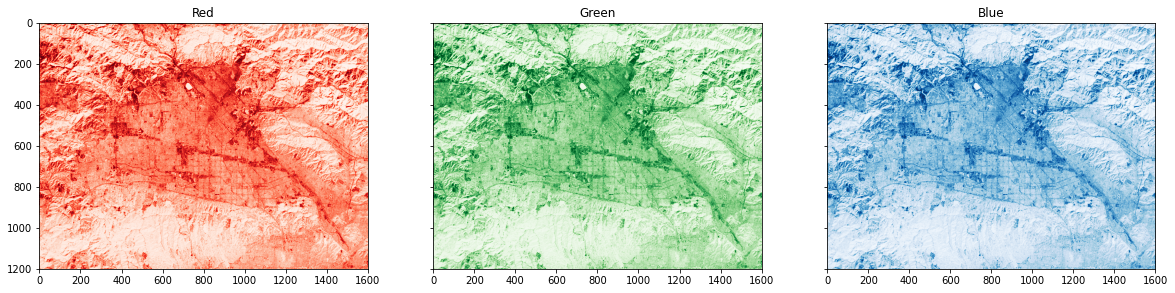

In [37]:
# display the different layers side by side
%matplotlib inline

# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20, 10), sharey=True)

# Plot Red, Green and Blue (rgb)
show((naip_tif, 1), cmap='Reds', ax=ax1)
show((naip_tif, 1), cmap='Greens', ax=ax2)
show((naip_tif, 1), cmap='Blues', ax=ax3)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")

# Normalising the satelite image

We can reduce the radiometric impacts induced by non-surface factors by normalizing a satellite image. This ensures that the difference in grey values between temporal images accurately reflects actual changes in the Earth's surface.

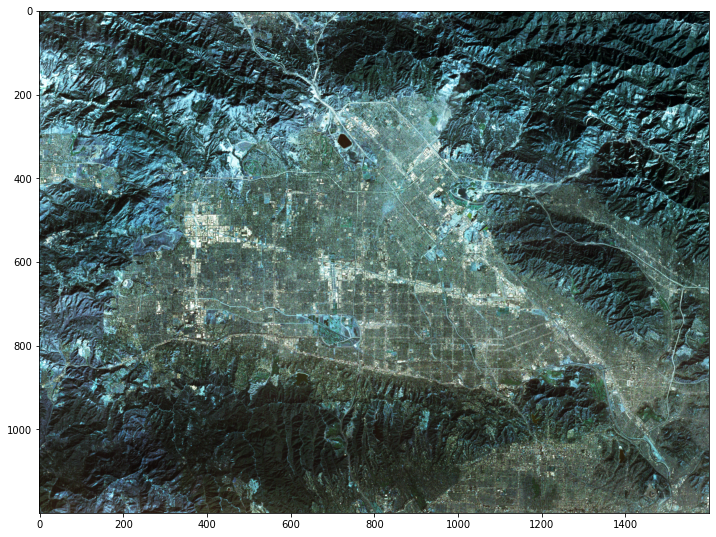

In [38]:
# Normalise bands into 0.0 - 1.0 scale
# this is done for the plotting of the image
def normalise(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Convert to numpy arrays
# the order is from the tiff we created earlier
# the SAME can be achieved by reading the original separate channels
# in that case you need to read the first one for each, so for
# example: blue = b2.read(1)
blue = naip_tif.read(3)
green = naip_tif.read(2)
red = naip_tif.read(1)

# Normalise band DN (this is done for the plotting in Python so that matlap can
# read the colour range correctly)
blue_norm = normalise(blue)
green_norm = normalise(green)
red_norm = normalise(red)

# Stack bands
rgb_cc = np.dstack((blue_norm, green_norm, red_norm))

# View the colour composite
plt.figure(figsize = (12,10))
plt.imshow(rgb_cc)

In [39]:
# let's also have a look at these new image values
print("Normalised bands:")
print(red_norm.min(), '-', red_norm.max(), 'mean:', red_norm.mean())
print(green_norm.min(), '-', green_norm.max(), 'mean:', green_norm.mean())
print(blue_norm.min(), '-', blue_norm.max(), 'mean:', blue_norm.mean())

Normalised bands:
0.0 - 1.0 mean: 0.345961299019608
0.0 - 1.0 mean: 0.3560679697712419
0.0 - 1.0 mean: 0.2693508455882352


## Working with the bands

In [40]:
!gdown https://drive.google.com/uc?id=1wWhUElozRZRl69m1mn_glosTz6nbqLBk

Downloading...
From: https://drive.google.com/uc?id=1wWhUElozRZRl69m1mn_glosTz6nbqLBk
To: /content/Archive.zip
100% 31.5M/31.5M [00:00<00:00, 91.4MB/s]


In [41]:
!unzip Archive.zip

Archive:  Archive.zip
replace B04-19940117.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: B04-19940117.tif        
replace __MACOSX/._B04-19940117.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._B04-19940117.tif  
replace B01-19940117.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: B01-19940117.tif        
replace __MACOSX/._B01-19940117.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._B01-19940117.tif  
replace B03-19940117.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: B03-19940117.tif        
replace __MACOSX/._B03-19940117.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: yy
  inflating: __MACOSX/._B03-19940117.tif  
replace B08-19940117.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: B08-19940117.tif        
replace __MACOSX/._B08-19940117.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._B08-19940117.tif  
replace B07-19940117.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: B0

Depending on how you access satellite imagery, the bands are going to be presented either in separate files, or in one file with multiple layers. In this case, i have separate files to manipulate

This data from here: https://landsatlook.usgs.gov/explore?sat=LANDSAT_5&date=1994-01-17%7C1994-01-18&preset=custom1&presetSingle=qa



In [42]:
# Bands
b1 = rio.open(r"../content/B01-19940117.tif")
b2 = rio.open(r"../content/B02-19940117.tif")
b3 = rio.open(r"../content/B03-19940117.tif")
b4 = rio.open(r"../content/B04-19940117.tif")
b5 = rio.open(r"../content/B05-19940117.tif")
b6 = rio.open(r"../content/B06-19940117.tif")
b7 = rio.open(r"../content/B07-19940117.tif")
b8 = rio.open(r"../content/B08-19940117.tif")

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


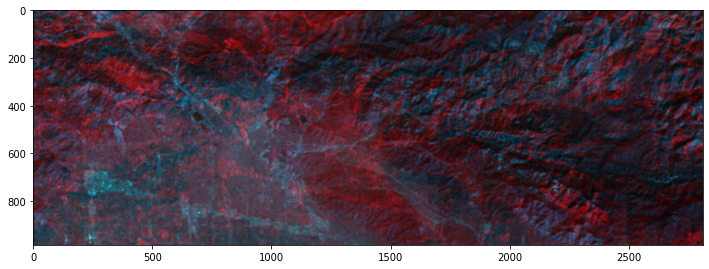

In [43]:
# this is the same principle as before:
# Read the grid values into numpy arrays
nir = b1.read(1)
red = b4.read(1)
green = b3.read(1)

# Normalise the values using the function that we defined earlier
nir_norm = normalise(nir)
red_norm = normalise(red)
green_norm = normalise(green)

# Create the composite by stacking
nrg = np.dstack((nir_norm, red_norm, green_norm))

# Let's see how our false colour composite looks like
plt.figure(figsize = (12,10))
plt.imshow(nrg)

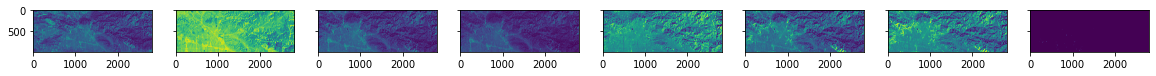

In [44]:
# display the different layers side by side
%matplotlib inline

# Initialize subplots
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(ncols=8, nrows=1, figsize=(20, 10), sharey=True)

# Plot Red, Green and Blue (rgb)
show((b1, 1), ax=ax1)
show((b2, 1), ax=ax2)
show((b3, 1), ax=ax3)

show((b4, 1), ax=ax4)
show((b5, 1), ax=ax5)
show((b6, 1), ax=ax6)

show((b7, 1), ax=ax7)
show((b8, 1), ax=ax8)

## Calculate NDWI
NDWI and its purpose and usage has been discussed in last week's lecture slides

Formula: (Band3 — Band8)/(Band3 + Band8)

In [45]:
green = b3.read(1)
nir = b1.read(1)

ndwi = (nir.astype(float)-green.astype(float))/(nir+green)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


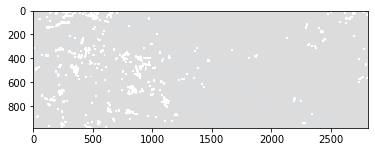

In [46]:
fig, ax = plt.subplots(1)
show(ndwi, ax=ax, cmap="coolwarm_r")
plt.show()

# More earthquake satelite image

In this step, will investigate Japan Earthquake.
Provided from this link: https://photojournal.jpl.nasa.gov/catalog/PIA13976

The above section, which contained earthquakes in the United States, did not contain any earthquakes with a magnitude greater than 9.0, so we looked at Japan's earthquake, which had a magnitude greater than 9.0 this time.
The ground displacements caused by the magnitude 9.0 Tohoku earthquake in Japan are depicted in this radar image. It was developed using satellite data from the European Space Agency's Envisat Advanced Synthetic Aperture Radar by the NASA Jet Propulsion Laboratory/Caltech ARIA project. The image was constructed by comparing radar data gathered over the region on February 19, 2011 — before the major shock — and March 21, 2011, spanning the March 11 main shock and a later magnitude 7.9 aftershock. In the radar's line of sight, one color cycle (from purple to yellow to green to blue and back to purple) signifies 50 centimeters of ground motion (approximately west at 41 degrees from vertical). This interferogram measures a total surface displacement in the line of sight of around 2.5 meters (8.3 feet).


In [47]:
fpath_ = "https://photojournal.jpl.nasa.gov/tiff/PIA13976.tif"

def rasterio_open(f):
    return rio.open(f)

tif_img = rasterio_open(fpath_)

radar = rxr.open_rasterio(tif_img, masked=True)
radar

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


<xarray.DataArray (band: 3, y: 7680, x: 2768)>
[63774720 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 2.766e+03 2.766e+03 2.768e+03
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 7.678e+03 7.678e+03 7.68e+03
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

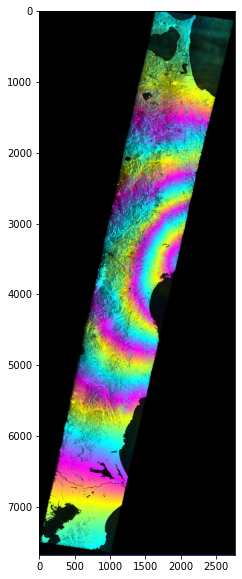

In [48]:
# Plot the area
fig, ax = plt.subplots(1, figsize=(12, 10))
show(tif_img, ax=ax)
plt.show()

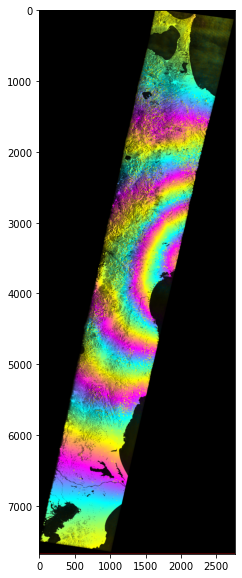

In [49]:
# Normalise bands into 0.0 - 1.0 scale
# this is done for the plotting of the image
def normalise(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

blue = tif_img.read(3)
green = tif_img.read(2)
red = tif_img.read(1)

# Normalise band DN (this is done for the plotting in Python so that matlap can
# read the colour range correctly)
blue_norm = normalise(blue)
green_norm = normalise(green)
red_norm = normalise(red)

# Stack bands
rgb_cc = np.dstack((blue_norm, green_norm, red_norm))

# View the colour composite
plt.figure(figsize = (12,10))
plt.imshow(rgb_cc)

Looking at this DataArray compared to the other one, we can see that this tif image has only come with three bands as opposed to the four like the other. This is somewhat unfortunate as we are missing the Near Infrared band so we can't go as indepth as we did with the previous image.

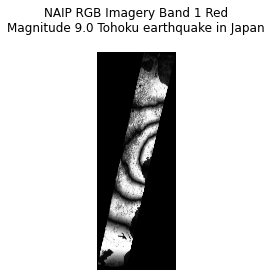

In [50]:
fig, ax = plt.subplots()

ax.imshow(radar[0], 
          cmap="Greys_r")
ax.set_title("NAIP RGB Imagery Band 1 Red\nMagnitude 9.0 Tohoku earthquake in Japan\n")
ax.set_axis_off()
plt.show()

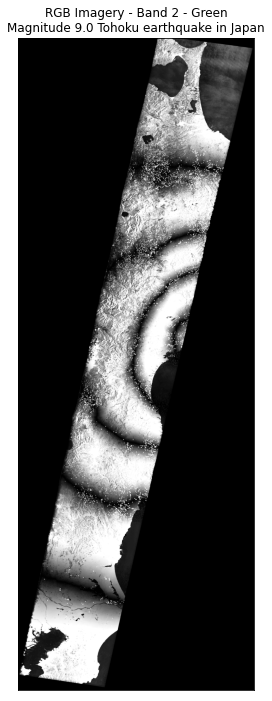

In [51]:
# Plot band 2 - green
ep.plot_bands(radar[1],
              title="RGB Imagery - Band 2 - Green\nMagnitude 9.0 Tohoku earthquake in Japan",
              cbar=False)
plt.show()

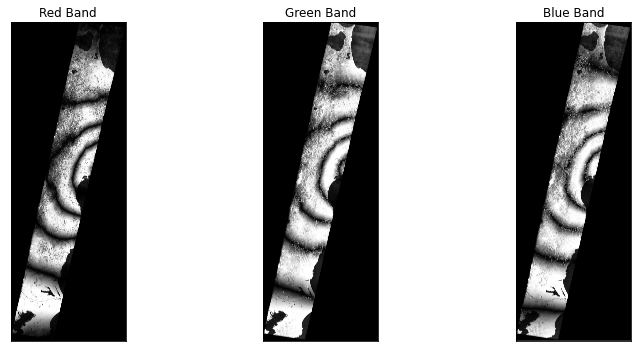

In [52]:
titles = ["Red Band", "Green Band", "Blue Band"]

# Plot all bands using the earthpy function
ep.plot_bands(radar, 
              figsize=(12, 5), 
              cols=3,
              title=titles,
              cbar=False)
plt.show()

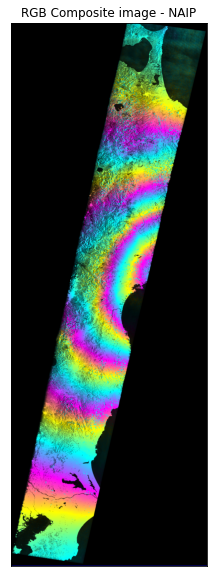

In [53]:
ep.plot_rgb(radar.values,
            rgb=[0, 1, 2],
            title="RGB Composite image - NAIP")
plt.show()

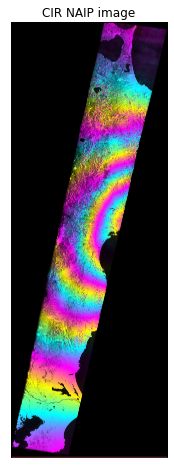

In [54]:
# This is just an idea of how we would switch the bands around to make up different images
ep.plot_rgb(radar.values, title="CIR NAIP image",
            rgb=[2, 0, 1],
            figsize=(10, 8))
plt.show()

with the above radar image, this google overlay image depicts ground displacements resulting from the March 11, 2011, magnitude 9.0 Tohoku earthquake in Japan, overlaid on a map of recent earthquake activity from the U.S. Geological Survey

In [55]:
fpath_1 = "https://photojournal.jpl.nasa.gov/tiff/PIA13975.tif"

def rasterio_open(f):
    return rio.open(f)

google_tiff = rasterio_open(fpath_1)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


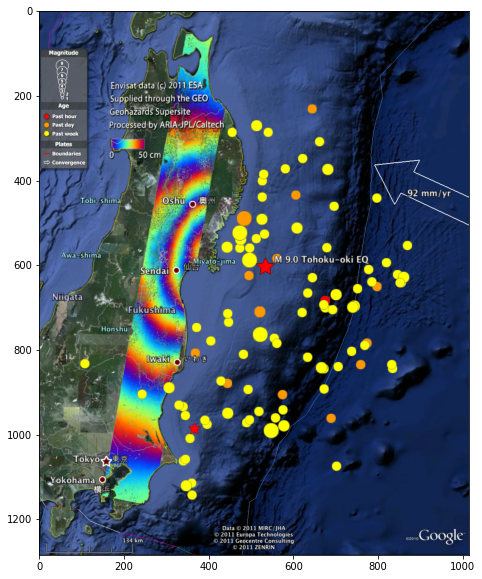

In [56]:
# Plot the area
fig, ax = plt.subplots(1, figsize=(12, 10))
show(google_tiff, ax=ax)
plt.show()

# Predicting Earthquake 

It is common knowledge that if a disaster has occurred in a given place, it is likely to occur again. Some areas do have a high frequency of earthquakes, however this is just in comparison to other areas. So, anticipating an earthquake based on past data such as Date and Time, Latitude and Longitude is not a pattern that follows like other things; it is a natural occurrence.


In [57]:
df.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Magnitude',
       'ID', 'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')

Create an object with the primary features from the earthquake dataset, such as Date, Time, Latitude, Longitude, Depth, and Magnitude.

In [58]:
data = df[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]

In [59]:
data.head()

Date      Time  Latitude  Longitude  Depth  Magnitude
0  01/02/1965  13:44:18    19.246    145.616  131.6        6.0
1  01/04/1965  11:29:49     1.863    127.352   80.0        5.8
2  01/05/1965  18:05:58   -20.579   -173.972   20.0        6.2
3  01/08/1965  18:49:43   -59.076    -23.557   15.0        5.8
4  01/09/1965  13:32:50    11.938    126.427   15.0        5.8

Combine date and time for training model later

In [60]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        timestamp.append('ValueError')

In [61]:
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
data = data.drop(['Date', 'Time'], axis=1)
data = data[data.Timestamp != 'ValueError']
data.head()

Latitude  Longitude  Depth  Magnitude    Timestamp
0    19.246    145.616  131.6        6.0 -157630542.0
1     1.863    127.352   80.0        5.8 -157465811.0
2   -20.579   -173.972   20.0        6.2 -157355642.0
3   -59.076    -23.557   15.0        5.8 -157093817.0
4    11.938    126.427   15.0        5.8 -157026430.0

All of the earthquakes from the database are represented on a world map, which offers a clear depiction of the areas where earthquakes will occur more frequently.

In [63]:
!pip install basemap

In [64]:
from mpl_toolkits.basemap import Basemap

m_= Basemap(projection='mill', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()

x,y = m_(longitudes,latitudes)

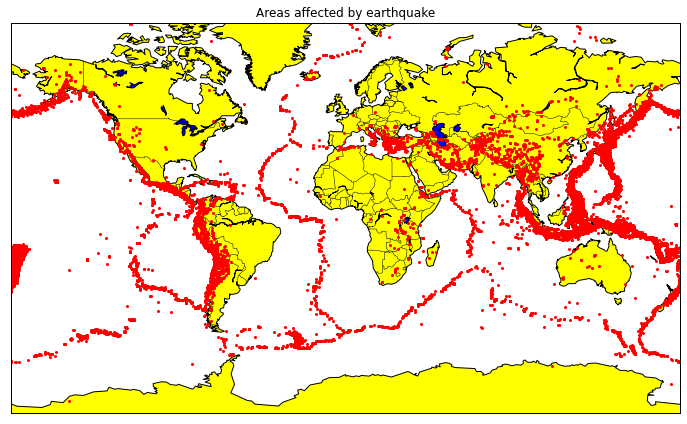

In [65]:
fig = plt.figure(figsize=(12,10))
plt.title("Areas affected by earthquake")
m_.plot(x, y, "o", markersize = 2, color = 'red')
m_.drawcoastlines()
m_.fillcontinents(color='yellow', lake_color='blue')
m_.drawmapboundary()
m_.drawcountries()
plt.show()

## Splitting the data
To begin, split the data into Xs and ys, which represent the model's input and output, respectively. TImestamp, Latitude, and Longitude are the inputs, and Magnitude and Depth are the outputs. Divide the Xs and Ys into two groups: training and testing with validation. The Training dataset contains 80% of the data, while the Test dataset contains 20%.

In [66]:
X = data[['Timestamp', 'Latitude', 'Longitude']]
y = data[['Magnitude', 'Depth']]

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

(18729, 3) (4683, 3) (18729, 2) (4683, 3)


I used the RandomForestRegressor model to predict the outputs, and observe an odd prediction with a score of more than 80%, which can be presumed to be the best fit but not due to the anticipated values.

In [81]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state = 42)
regressor.fit(X_train, y_train)
regressor.predict(X_test)

array([[  5.938 ,  61.962 ],
       [  5.626 ,  10.374 ],
       [  5.672 ,  65.909 ],
       ...,
       [  5.918 , 208.139 ],
       [  5.962 ,  33.197 ],
       [  5.729 ,  33.0061]])

In [77]:
regressor.score(X_test, y_test)

0.386838978824785

In [70]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10, 20, 50, 100, 200, 500]}

grid_obj = GridSearchCV(regressor, parameters)
grid_fit = grid_obj.fit(X_train, y_train)
best_fit = grid_fit.best_estimator_
best_fit.predict(X_test)

array([[  5.9062,  63.1742],
       [  5.6756,  10.5444],
       [  5.7052,  61.629 ],
       ...,
       [  5.928 , 208.3442],
       [  5.9758,  34.4778],
       [  5.723 ,  34.3411]])

In [71]:
best_fit.score(X_test, y_test)

0.3910744071348401

# Neural Network Model

It was more of a linear regressor in the above step, where the anticipated values were not as expected also not accurate. Now I'm going to create a neural network to fit the data for the training set. Three Dense layers with 16, 16, 2 nodes each and relu, and softmax as activation functions make up a Neural Network.

In [82]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

defining the hyperparameter with two or more, finding best fit

In [83]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Got the mean test score and standard deviation of the best fit model.

In [84]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.774690 using {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}
0.400000 (0.489898) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.400000 (0.489898) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}
0.025097 (0.030783) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.774690 (0.388382) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}


To compute the score with training and testing data, the best fit parameters are used for the same model.

In [85]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
1873/1873 [==============================] - 9s 5ms/step - loss: 0.5038 - accuracy: 0.9180 - val_loss: 0.5037 - val_accuracy: 0.9250
Epoch 2/20
1873/1873 [==============================] - 8s 5ms/step - loss: 0.5038 - accuracy: 0.9180 - val_loss: 0.5037 - val_accuracy: 0.9250
Epoch 3/20
1873/1873 [==============================] - 8s 4ms/step - loss: 0.5038 - accuracy: 0.9180 - val_loss: 0.5037 - val_accuracy: 0.9250
Epoch 4/20
1873/1873 [==============================] - 8s 4ms/step - loss: 0.5038 - accuracy: 0.9180 - val_loss: 0.5037 - val_accuracy: 0.9250
Epoch 5/20
1873/1873 [==============================] - 8s 4ms/step - loss: 0.5038 - accuracy: 0.9180 - val_loss: 0.5037 - val_accuracy: 0.9250
Epoch 6/20
1873/1873 [==============================] - 8s 5ms/step - loss: 0.5038 - accuracy: 0.9180 - val_loss: 0.5037 - val_accuracy: 0.9250
Epoch 7/20
1873/1873 [==============================] - 9s 5ms/step - loss: 0.5038 - accuracy: 0.9180 - val_loss: 0.5037 - val_accuracy:

In [86]:
[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

147/147 [==============================] - 0s 3ms/step - loss: 0.5037 - accuracy: 0.9250
Evaluation result on Test Data : Loss = 0.5036913752555847, accuracy = 0.9250480532646179
